# Title I Allocations w/ DP ACS

In [1]:
from dp_policy.experiments import titlei_funding as funding, titlei_grid as test_params
from dp_policy.titlei.allocators import AbowdAllocator, SonnenbergAuthorizer
from dp_policy.titlei.utils import weighting
from dp_policy.titlei.mechanisms import Laplace, Gaussian, GroundTruth
from dp_policy.titlei.utils import *
from dp_policy.titlei.thresholders import *
from dp_policy.titlei.evaluation import *
from dp_policy.experiments import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

saipe = get_inputs(2021)
sppe = get_sppe("../data/sppe18.xlsx")
print(saipe.shape)

plt.style.use('seaborn-deep')

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/rsteed/dp-acs
[INFO] Successfully imputed 2937 new indices
-- WARNING: dropping some balances from total budget --
Puerto Rico 412450771.2306171
County balances 723748.7996060263
Part D Subpart 2 104168000.98352575
(13190, 24)


## Allocation Algorithm

### Data
Need state per-pupil expenditure (SPPE) from the NCES. Most recent I can find in <5min is the [FY '18 data](https://nces.ed.gov/pubsearch/pubsinfo.asp?pubid=2020308).

Had to use an online tool to convert Table 2 of [this report](https://nces.ed.gov/pubs2020/2020308.pdf).

In [3]:
sppe = get_sppe("../data/sppe18.xlsx")
sppe.head()

state    ppe abbrv
0         Alabama   9697    AL
1          Alaska  17726    AK
2  American Samoa    NaN    AS
3         Arizona   8296    AZ
4        Arkansas  10072    AR

Also need a dict matching district IDs to district names to states. Simplest to use [SAIPE 2019](https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-school-districts/) ground-truth.

Also, a method for roughly estimating standard errors for the SAIPE estimates, based on [these published docs](https://www.census.gov/programs-surveys/saipe/guidance/district-estimates.html). This could be improved - but start with this as a shortcut.

In [62]:
saipe.head()

State Postal Code                         Name  \
State FIPS Code District ID                                                  
1               1                          AL  Fort Rucker School District   
                1                          AL  Fort Rucker School District   
                1                          AL  Fort Rucker School District   
                1                          AL  Fort Rucker School District   
                1                          AL  Fort Rucker School District   

                             Estimated Total Population  \
State FIPS Code District ID                               
1               1                                  4547   
                1                                  4547   
                1                                  4547   
                1                                  4547   
                1                                  4547   

                             Estimated Population 5-17  \
State FIPS Code District ID                              
1               1                                  861   
                1                                  861   
                1                                  861   
                1                                  861   
                1                                  861   

                             Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder  \
State FIPS Code District ID                                                                                                          
1               1                                                          133                                                       
                1                                                          133                                                       
                1                                                          133                                                       
                1                                                          133                                                       
                1                                                          133                                                       

                               cv     LEAID  Sort C    State  \
State FIPS Code District ID                                    
1               1            0.42  100001.0     1.0  ALABAMA   
                1            0.42  100003.0     1.0  ALABAMA   
                1            0.42  100005.0     1.0  ALABAMA   
                1            0.42  100006.0     1.0  ALABAMA   
                1            0.42  100007.0     1.0  ALABAMA   

                             Basic Hold Harmless  ...  \
State FIPS Code District ID                       ...   
1               1                   6.145069e+04  ...   
                1                   2.085941e+04  ...   
                1                   8.205345e+05  ...   
                1                   1.319212e+06  ...   
                1                   6.089449e+05  ...   

                             Hold Harmless Percentage  Resident Pop.  \
State FIPS Code District ID                                            
1               1                            1.505202         4547.0   
                1                            0.850000         2482.0   
                1                            0.900000        22051.0   
                1                            0.901848        49087.0   
                1                            0.936605        83044.0   

                             Total Formula Count  5-17 Pop.  Percent Formula  \
State FIPS Code District ID                                                    
1               1                          135.0      861.0         0.156794   
                1                           27.0      243.0         0.111111   
                1                          971.

In [63]:
# average school district student pop
saipe["Estimated Population 5-17"].mean()
saipe["Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder"].mean()

104.63089683773975

### Code

Next, a class for the different ways we might allocate funds based on the poverty estimates (e.g. Abowd's shortcut method vs. the full Sonnenberg method).

Finally, the main method for computing estimates, then grant amounts.

-- WARNING: dropping some balances from total budget --
Puerto Rico 413911155.7939328
County balances 728460.8149536257
Part D Subpart 2 98548579.79236995
15836763981.599205


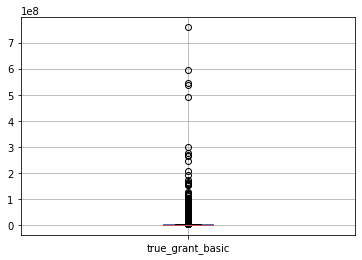

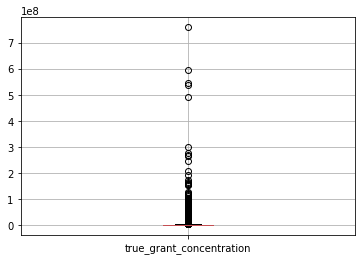

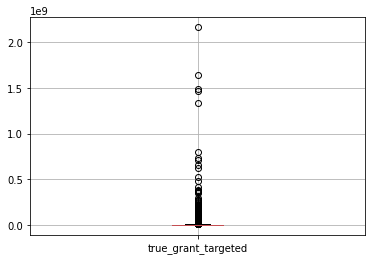

In [236]:
# Test with ground truth mechanism
saipe = get_inputs(2021)
grants = funding(SonnenbergAuthorizer, saipe, GroundTruth(), get_sppe("../data/sppe18.xlsx"))
grants.boxplot('true_grant_basic')
plt.show()
grants.boxplot('true_grant_concentration')
plt.show()
grants.boxplot('true_grant_targeted')
plt.show()

## Ground Truth Comparison
How close are our allocation estimates to the actual allocations from 2019? Note that we only have 2020's allocations, when really we need 2021's allocations, which will use the 2019 ACS data (see [here](https://www.nd.gov/dpi/sites/www/files/documents/Educational%20Equity%20%26%20Support/Title%20I/USED%20Census%202019%20Memo.pdf)). But historically the numbers are close.

-- WARNING: dropping some balances from total budget --
Puerto Rico 412450771.2306171
County balances 723748.7996060263
Part D Subpart 2 104168000.98352575
total
Average error -7.060823158570724e-11
RMSE 267898.8913773343 (average alloc is 1200349.4811968347 )


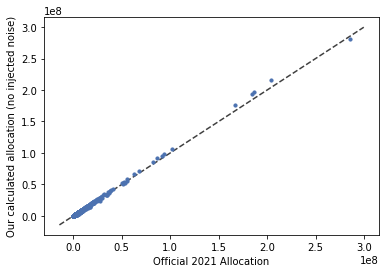

Name  official_basic_hold_harmless  \
State FIPS Code District ID                                               
36              82047        Kings County                  8.827453e+07   

                             official_concentration_hold_harmless  \
State FIPS Code District ID                                         
36              82047                                2.182134e+07   

                             official_targeted_hold_harmless  \
State FIPS Code District ID                                    
36              82047                           9.270965e+07   

                             official_efig_hold_harmless  \
State FIPS Code District ID                                
36              82047                       8.319514e+07   

                             official_total_hold_harmless  \
State FIPS Code District ID                                 
36              82047                        2.860007e+08   

                             official_basic_alloc  \
State FIPS Code District ID                         
36              82047                8.712931e+07   

                             official_concentration_alloc  \
State FIPS Code District ID                                 
36              82047                        2.210905e+07   

                             official_targeted_alloc  official_efig_alloc  \
State FIPS Code District ID                                                 
36              82047                   9.498686e+07         8.667319e+07   

                             ...  dpest_eligible_basic  \
State FIPS Code District ID  ...                         
36              82047        ...                  True   

                             dpest_grant_concentration  \
State FIPS Code District ID                              
36              82047                     2.172240e+07   

                             dpest_eligible_concentration  \
State FIPS Code District ID                                 
36              82047                                True   

                             dpest_grant_targeted  dpest_eligible_targeted  \
State FIPS Code District ID                                                  
36              82047                8.466005e+07                     True   

                             true_grant_total  est_grant_total  \
State FIPS Code District ID                                      
36              82047            2.153510e+08     1.844383e+08   

                             dp_grant_total  dpest_grant_total         error  
State FIPS Code District ID                                                   
36              82047          2.153510e+08       1.844383e+08 -1.112577e+07  

[1 rows x 67 columns]

basic
Average error -1.0450018274684671e-11
RMSE 93867.8964035751 (average alloc is 1200349.4811968347 )


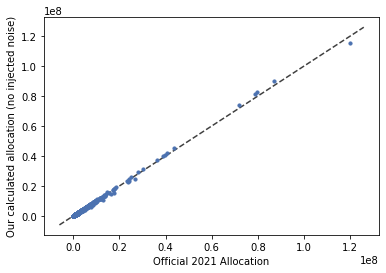

Name  official_basic_hold_harmless  \
State FIPS Code District ID                                               
36              82047        Kings County                  8.827453e+07   

                             official_concentration_hold_harmless  \
State FIPS Code District ID                                         
36              82047                                2.182134e+07   

                             official_targeted_hold_harmless  \
State FIPS Code District ID                                    
36              82047                           9.270965e+07   

                             official_efig_hold_harmless  \
State FIPS Code District ID                                
36              82047                       8.319514e+07   

                             official_total_hold_harmless  \
State FIPS Code District ID                                 
36              82047                        2.860007e+08   

                             official_basic_alloc  \
State FIPS Code District ID                         
36              82047                8.712931e+07   

                             official_concentration_alloc  \
State FIPS Code District ID                                 
36              82047                        2.210905e+07   

                             official_targeted_alloc  official_efig_alloc  \
State FIPS Code District ID                                                 
36              82047                   9.498686e+07         8.667319e+07   

                             ...  dpest_eligible_basic  \
State FIPS Code District ID  ...                         
36              82047        ...                  True   

                             dpest_grant_concentration  \
State FIPS Code District ID                              
36              82047                     3.247885e+07   

                             dpest_eligible_concentration  \
State FIPS Code District ID                                 
36              82047                                True   

                             dpest_grant_targeted  dpest_eligible_targeted  \
State FIPS Code District ID                                                  
36              82047                1.304930e+08                     True   

                             true_grant_total  est_grant_total  \
State FIPS Code District ID                                      
36              82047            2.153510e+08     2.794623e+08   

                             dp_grant_total  dpest_grant_total         error  
State FIPS Code District ID                                                   
36              82047          2.153510e+08       2.794623e+08 -2.907847e+06  

[1 rows x 67 columns]

concentration
Average error -1.5745635643612715e-11
RMSE 85392.67792116926 (average alloc is 1200349.4811968347 )


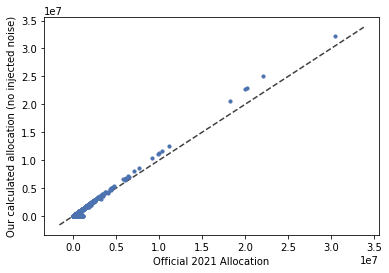

Name  official_basic_hold_harmless  \
State FIPS Code District ID                                               
36              82047        Kings County                  8.827453e+07   

                             official_concentration_hold_harmless  \
State FIPS Code District ID                                         
36              82047                                2.182134e+07   

                             official_targeted_hold_harmless  \
State FIPS Code District ID                                    
36              82047                           9.270965e+07   

                             official_efig_hold_harmless  \
State FIPS Code District ID                                
36              82047                       8.319514e+07   

                             official_total_hold_harmless  \
State FIPS Code District ID                                 
36              82047                        2.860007e+08   

                             official_basic_alloc  \
State FIPS Code District ID                         
36              82047                8.712931e+07   

                             official_concentration_alloc  \
State FIPS Code District ID                                 
36              82047                        2.210905e+07   

                             official_targeted_alloc  official_efig_alloc  \
State FIPS Code District ID                                                 
36              82047                   9.498686e+07         8.667319e+07   

                             ...  dpest_eligible_basic  \
State FIPS Code District ID  ...                         
36              82047        ...                  True   

                             dpest_grant_concentration  \
State FIPS Code District ID                              
36              82047                     3.070087e+07   

                             dpest_eligible_concentration  \
State FIPS Code District ID                                 
36              82047                                True   

                             dpest_grant_targeted  dpest_eligible_targeted  \
State FIPS Code District ID                                                  
36              82047                1.219005e+08                     True   

                             true_grant_total  est_grant_total  \
State FIPS Code District ID                                      
36              82047            2.153510e+08     2.623403e+08   

                             dp_grant_total  dpest_grant_total         error  
State FIPS Code District ID                                                   
36              82047          2.153510e+08       2.623403e+08 -2.931902e+06  

[1 rows x 67 columns]

targeted
Average error -4.6036566993881124e-11
RMSE 123934.14686914106 (average alloc is 1200349.4811968347 )


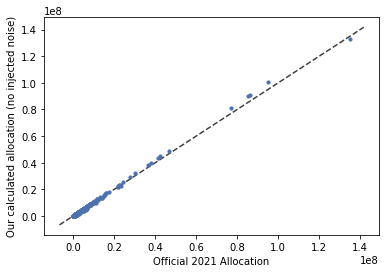

Name  official_basic_hold_harmless  \
State FIPS Code District ID                                               
36              82047        Kings County                  8.827453e+07   

                             official_concentration_hold_harmless  \
State FIPS Code District ID                                         
36              82047                                2.182134e+07   

                             official_targeted_hold_harmless  \
State FIPS Code District ID                                    
36              82047                           9.270965e+07   

                             official_efig_hold_harmless  \
State FIPS Code District ID                                
36              82047                       8.319514e+07   

                             official_total_hold_harmless  \
State FIPS Code District ID                                 
36              82047                        2.860007e+08   

                             official_basic_alloc  \
State FIPS Code District ID                         
36              82047                8.712931e+07   

                             official_concentration_alloc  \
State FIPS Code District ID                                 
36              82047                        2.210905e+07   

                             official_targeted_alloc  official_efig_alloc  \
State FIPS Code District ID                                                 
36              82047                   9.498686e+07         8.667319e+07   

                             ...  dpest_eligible_basic  \
State FIPS Code District ID  ...                         
36              82047        ...                  True   

                             dpest_grant_concentration  \
State FIPS Code District ID                              
36              82047                     2.632713e+07   

                             dpest_eligible_concentration  \
State FIPS Code District ID                                 
36              82047                                True   

                             dpest_grant_targeted  dpest_eligible_targeted  \
State FIPS Code District ID                                                  
36              82047                1.036225e+08                     True   

                             true_grant_total  est_grant_total  \
State FIPS Code District ID                                      
36              82047            2.153510e+08     2.242385e+08   

                             dp_grant_total  dpest_grant_total         error  
State FIPS Code District ID                                                   
36              82047          2.153510e+08       2.242385e+08 -5.286022e+06  

[1 rows x 67 columns]

In [4]:
saipe = get_inputs(2021)
def compare_allocs(grant_type="total", **kwargs):
    allocs = funding(
        SonnenbergAuthorizer, saipe, GroundTruth(), sppe,
        allocator_kwargs=kwargs
    )
    if grant_type == "total":
        official = allocs[f"official_total_alloc"] - allocs[f"official_efig_alloc"]
    else:
        official = allocs[f"official_{grant_type}_alloc"]
    calculated = allocs[f"true_grant_{grant_type}"]
    allocs["error"] = official - calculated
    print("Average error", allocs.error.mean())
    print(
        "RMSE", 
        np.sqrt(np.mean(np.power(allocs.error, 2))), 
        "(average alloc is", 
        np.mean(allocs[f"official_total_alloc"]), 
        ")"
    )

    ax = plt.gca()
    plt.scatter(official, calculated, s=10)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    plt.xlabel("Official 2021 Allocation")
    plt.ylabel("Our calculated allocation (no injected noise)")
    plt.savefig(f"../plots/robustness/official_{grant_type}.png", dpi=300)
    plt.show()

    # plt.hist(allocs.error, bins=50)
    # plt.show()

    display(allocs[allocs.error == allocs.error.min()])

for grant_type in ["total", "basic", "concentration", "targeted"]:
    print(grant_type)
    compare_allocs(grant_type=grant_type)

## Laplace

### Results
First, using the full Sonnenberg authorization algo.

In [2]:
results = test_params(saipe, Laplace, eps=[0.1, 1.0, 2.52, 10.0]+list(np.logspace(-4, 1, num=10)), trials=100, print_results=False)
pickle.dump(results, open("../results/titlei_laplace.pkl", 'wb'))

1400 iters:


trial: 100%|██████████| 100/100 [1:24:58<00:00, 50.98s/it]


In [4]:
results = pickle.load(open("../results/titlei_laplace.pkl", 'rb'))

100
## est
## basic grants - eps=0.1 ##
# districts: 1319000
Average true alloc: 469099.6911697106
Max true alloc: 115755955.49502522
Max error: 44196268.142646536
RMSE: 340272.5536068515
RMSE in exp. error: 30512.13209855803
Avg. sum of negative misallocs: 49503624.565535665
Avg. total misalloc: 99007249.13107146
# small districts: 9744
Total avg misalloc to large districts: 66868621.396521
Total avg misalloc to small districts: 32138627.734550066
Avg total true alloc: 6187424926.528488
## concentration grants - eps=0.1 ##
# districts: 1319000
Average true alloc: 98353.3515922628
Max true alloc: 32193815.515176307
Max error: 12277672.10157419
RMSE: 112635.5688528438
RMSE in exp. error: 32228.83052558881
Avg. sum of negative misallocs: 65961028.4252485
Avg. total misalloc: 131922056.85049732
# small districts: 9744
Total avg misalloc to large districts: 87819002.136038
Total avg misalloc to small districts: 44103054.714458995
Avg total true alloc: 1297280707.5019464
## targeted grants 

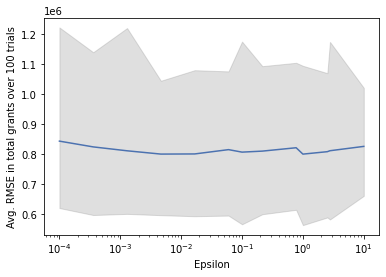

## dp
## basic grants - eps=0.1 ##
# districts: 1319000
Average true alloc: 469099.6911697106
Max true alloc: 115755955.49502522
Max error: 359483.0559287369
RMSE: 21646.150702138995
RMSE in exp. error: 6185.606253613026
Avg. sum of negative misallocs: 19807643.39011451
Avg. total misalloc: 39615286.78022877
# small districts: 9744
Total avg misalloc to large districts: 14418027.459835514
Total avg misalloc to small districts: 25197259.320393346
Avg total true alloc: 6187424926.528488
## concentration grants - eps=0.1 ##
# districts: 1319000
Average true alloc: 98353.3515922628
Max true alloc: 32193815.515176307
Max error: 1346188.9666000553
RMSE: 17102.092026746832
RMSE in exp. error: 9358.727891484306
Avg. sum of negative misallocs: 20300735.105213642
Avg. total misalloc: 40601470.21042711
# small districts: 9744
Total avg misalloc to large districts: 15604175.76357928
Total avg misalloc to small districts: 24997294.446847994
Avg total true alloc: 1297280707.5019464
## targeted grant

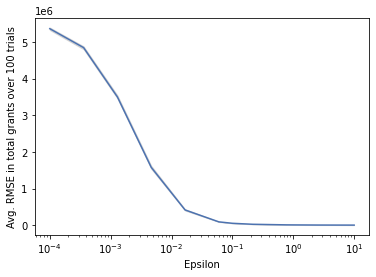

## dpest
## basic grants - eps=0.1 ##
# districts: 1319000
Average true alloc: 469099.6911697106
Max true alloc: 115755955.49502522
Max error: 44341032.72239865
RMSE: 340301.35513590084
RMSE in exp. error: 32021.29330037195
Avg. sum of negative misallocs: 56400900.18849592
Avg. total misalloc: 112801800.3769913
# small districts: 9744
Total avg misalloc to large districts: 68497827.276333
Total avg misalloc to small districts: 44303973.100658715
Avg total true alloc: 6187424926.528488
## concentration grants - eps=0.1 ##
# districts: 1319000
Average true alloc: 98353.3515922628
Max true alloc: 32193815.515176307
Max error: 12424890.936553873
RMSE: 112322.41454528183
RMSE in exp. error: 32986.7301610652
Avg. sum of negative misallocs: 71123456.02661335
Avg. total misalloc: 142246912.05322668
# small districts: 9744
Total avg misalloc to large districts: 90507902.39019561
Total avg misalloc to small districts: 51739009.6630311
Avg total true alloc: 1297280707.5019464
## targeted grants -

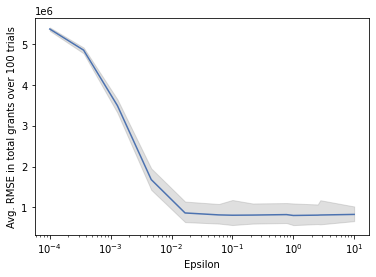

Name  \
trial delta epsilon State FIPS Code District ID                                        
0     0.0   0.1     1               190               Alabaster City School District   
                                    5               Albertville City School District   
                                    30           Alexander City City School District   
                                    60                Andalusia City School District   
                                    90                 Anniston City School District   
...                                                                              ...   
99    0.0   10.0    56              4260              Uinta County School District 6   
                                    6240           Washakie County School District 1   
                                    5820           Washakie County School District 2   
                                    4830             Weston County School District 1   
                                    6090             Weston County School District 7   

                                                 official_basic_hold_harmless  \
trial delta epsilon State FIPS Code District ID                                 
0     0.0   0.1     1               190                         451569.585546   
                                    5                           820486.906460   
                                    30                          548830.474149   
                                    60                          255888.455695   
                                    90                          690724.128654   
...                                                                       ...   
99    0.0   10.0    56              4260                         40822.247350   
                                    6240                        223321.706091   
                                    5820                             0.000000   
                                    4830                        182499.458741   
                                    6090                         20411.123675   

                                                 official_concentration_hold_harmless  \
trial delta epsilon State FIPS Code District ID                                         
0     0.0   0.1     1               190                                  58092.627841   
                                    5                                   200836.024036   
                                    30                                  135670.119992   
                                    60                                   63255.265741   
                                    90                                  170746.031480   
...                                                                               ...   
99    0.0   10.0    56              4260                                     0.000000   
                                    6240                                 24485.720477   
                                    5820                                  5762.953584   
                                    4830                                 93609.867864   
                                    6090                                     0.000000   

                                                 official_targeted_hold_harmless  \
trial delta epsilon State FIPS Code District ID                                    
0     0.0   0.1     1               190                            182516.637263   
                                    5                              553590.326339   
                                    30                             392958.114409   
                                    60                             157617.381627   
                                    90                             537272.595916   
...                                                                          ...   
99    0.0   10.0    56              4260           

In [6]:
print(len(results.groupby("trial")))
test_params(None, None, results=results, plot_results=True)

### Sanity check: using Abowd's method

Abowd reported a mean squared SPPE of 20 million from 2014-15 data.

In [12]:
grants = funding(AbowdAllocator, saipe, Laplace(2.52, 0, sensitivity=2.0), get_sppe("../data/sppe18.xlsx"))
print("Mean Sq. SPPE (2018):", np.mean(grants.adj_sppe**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
Mean Sq. SPPE (2018): 26235395.69087739


They also report an RMSE at e=2.52 of 2509 (again, using 2014-15 Common Core data, which I can't replicate) and 1334 at e=4.74 and 63000 at e=0.1. 

In [13]:
# RMSE
error = grants.true_grant_total - grants.dp_grant_total
np.sqrt(np.mean(error**2))

5729.419640458363

In [14]:
print("Total misalloc at eps=2.52:", sum(abs(error)))

Total misalloc at eps=2.52: 52390267.7563839


In [15]:
grants = funding(AbowdAllocator, saipe, Laplace(4.74, 0), get_sppe("../data/sppe18.xlsx"))
error = grants.true_grant_total - grants.dp_grant_total
np.sqrt(np.mean(error**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


3007.91078773349

In [17]:
grants = funding(AbowdAllocator, saipe, Laplace(0.1, 0), get_sppe("../data/sppe18.xlsx"))
error = grants.true_grant_total - grants.est_grant_total
np.sqrt(np.mean(error**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


2243651.00695352

## [DEPRECATED] Gaussian (Advanced Composition, Approx. DP)

Add Gaussian noise ln(1/delta)/epsilon for better accuracy bound.

/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/diffprivlib/mechanisms/gaussian.py:161: RuntimeWarning: overflow encountered in exp
  return phi(np.sqrt(epsilon * val)) - np.exp(epsilon) * phi(- np.sqrt(epsilon * (val + 2))) - delta
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/diffprivlib/mechanisms/gaussian.py:161: RuntimeWarning: invalid value encountered in double_scalars
  return phi(np.sqrt(epsilon * val)) - np.exp(epsilon) * phi(- np.sqrt(epsilon * (val + 2))) - delta
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/diffprivlib/mechanisms/gaussian.py:164: RuntimeWarning: overflow encountered in exp
  return phi(- np.sqrt(epsilon * val)) - np.exp(epsilon) * phi(- np.sqrt(epsilon * (val + 2))) - delta
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/diffprivlib/mechanisms/gaussian.py:164: RuntimeWarning: invalid value encountered in double_scalars
  return phi(- np.sqrt(epsilon * val)) - np.exp(epsilon) * phi(- np.sqrt(epsilon * (val + 2))) - delta


(0.001, 0.027825594022071243, 0.774263682681127, 2.52, 21.54434690031882, 599.4842503189409, 16681.005372000593, 464158.8833612772, 12915496.650148828, 359381366.3804626, 10000000000.0)
## dp
## basic grants ##
RMSE at eps=2.52: 21399.19796113853
RMSE prop eps=2.52: 0.004691125745169814
Total misalloc at eps=2.52: 1857499037.3476112
Total true alloc: 398753867558.1087
## concentration grants ##
RMSE at eps=2.52: 100671.3283797714
RMSE prop eps=2.52: 0.006430091290918551
Total misalloc at eps=2.52: 1869504093.5586305
Total true alloc: 294198199337.48425
## targeted grants ##
RMSE at eps=2.52: 56692.94880990919
RMSE prop eps=2.52: 0.004404833980625078
Total misalloc at eps=2.52: 2903765215.9326797
Total true alloc: 667259095030.0739
## total grants ##
RMSE at eps=2.52: 15266.238953544133
RMSE prop eps=2.52: 0.00492429570329448
Total misalloc at eps=2.52: 787839065.3432262
Total true alloc: 159990202216.03195


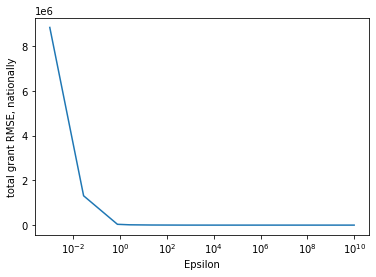

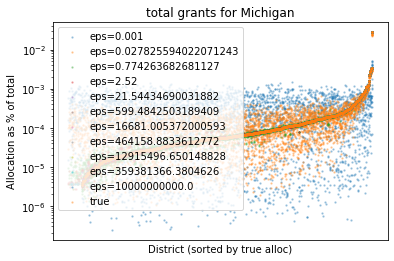

/Users/steed/dp-acs/dp_policy/api.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc['err_prop'] = (


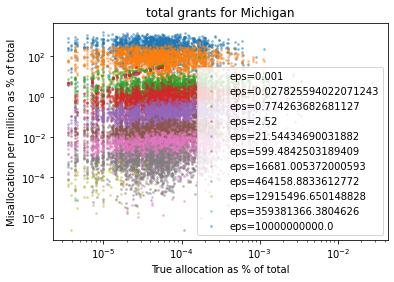

## dpest
## basic grants ##
RMSE at eps=2.52: 2730892.7708471036
RMSE prop eps=2.52: 0.1605220789051688
Total misalloc at eps=2.52: 64100091418.47471
Total true alloc: 398753867558.1087
## concentration grants ##
RMSE at eps=2.52: 3115379.4280794035
RMSE prop eps=2.52: 0.2559038715010952
Total misalloc at eps=2.52: 75780426908.8416
Total true alloc: 294198199337.48425
## targeted grants ##
RMSE at eps=2.52: 7905797.344754197
RMSE prop eps=2.52: 0.20086854941523397
Total misalloc at eps=2.52: 136090233079.47676
Total true alloc: 667259095030.0739
## total grants ##
RMSE at eps=2.52: 1550976.8201538778
RMSE prop eps=2.52: 0.20096552176913365
Total misalloc at eps=2.52: 32152514466.29373
Total true alloc: 159990202216.03195


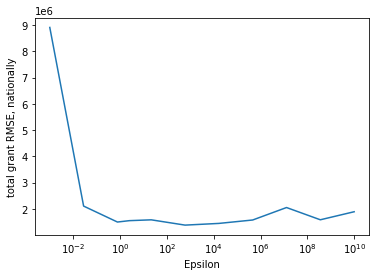

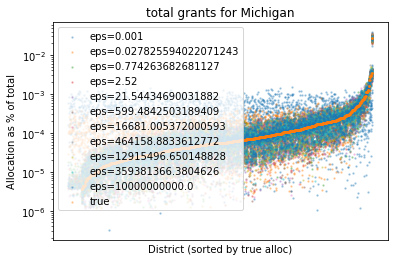

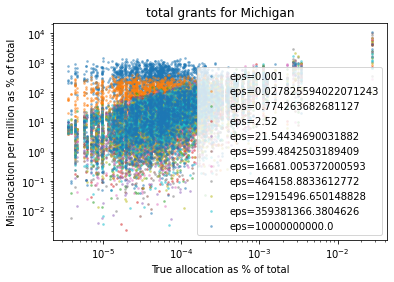

In [18]:
from dp_policy.titlei.mechanisms import Gaussian

# with delta = 0
results = test_params(
    saipe,
    Gaussian, 
    delta=list(np.linspace(1e-8, 1e-5, endpoint=False, num=10)),
    auth=False
)

Comparing dp


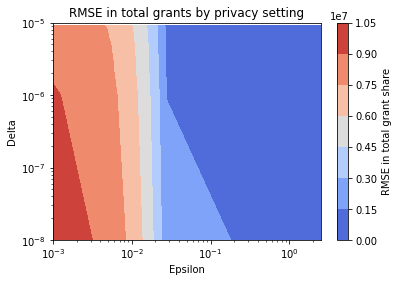

Comparing dpest


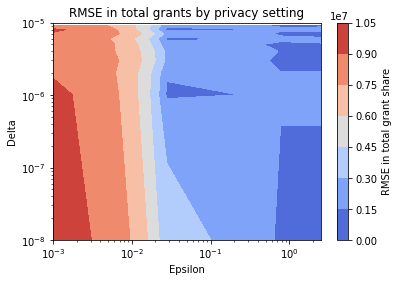

In [25]:
for prefix in ('dp', 'dpest'):
    print("Comparing", prefix)

    grant_type = 'total'

    eps = list(results.index.get_level_values("epsilon").unique())

    delts = list(results.index.get_level_values("delta").unique())
    mse = np.zeros((len(eps), len(delts)))
    for params, alloc in results.groupby(["epsilon", "delta"]):
        
        e, d = params
        error = alloc[f"true_grant_{grant_type}"] \
            - alloc[f"{prefix}_grant_{grant_type}"]
        mse[eps.index(e), delts.index(d)] = np.sqrt(sum(error**2)/alloc.shape[0])
        
    plt.contourf(eps, delts, mse.transpose(), cmap="coolwarm")
    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_yticks([1e-8, 1e-7, 1e-6, 1e-5])
    # ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    plt.xlim(None, 2.5)
    plt.xlabel("Epsilon")
    plt.ylabel("Delta")
    plt.title("RMSE in total grants by privacy setting")
    plt.colorbar(label="RMSE in total grant share")
    plt.show()

## Uncertainty

Adapted from `plot_sampling.ipynb`.

In [49]:
num_trials = 100
eps = [0.001, 0.01, 0.1, 1.0, 10]
num_bins = 10

In [3]:
laplace = test_params(saipe, Laplace, eps=[0.001, 0.01, 0.1, 1.0, 10], delta=[0.0], trials=num_trials, print_results=False, plot_results=False)
# gaussian = test_params(saipe, Gaussian, eps=[0.01, 0.1, 2.52], delta=[1e-6], trials=num_trials, print_results=False, plot_results=False)

pickle.dump(laplace, open("../results/bootstrap/laplace.pkl", 'wb'))
# pickle.dump(gaussian, open("../results/bootstrap/gaussian.pkl", 'wb'))

500 iters:


trial:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
baseline = test_params(saipe, GroundTruth, eps=[0.0], delta=[0.0], trials=num_trials, print_results=False, plot_results=False)
pickle.dump(baseline, open("../results/bootstrap/baseline.pkl", 'wb'))

In [50]:
baseline = pickle.load(open("../results/bootstrap/baseline.pkl", 'rb'))
laplace = pickle.load(open("../results/bootstrap/laplace.pkl", 'rb'))
# gaussian = pickle.load(open("../results/bootstrap/gaussian.pkl", 'rb'))

In [ ]:
treatments = {
  "+ Laplace mech. (ε={})".format(e): laplace.loc[pd.IndexSlice[:, 0.0, e, :, :], :].copy()
  for e in eps
}
treatments["Data error"] = baseline

plot_treatments(
  treatments,
  lambda df: df.groupby('trial')["lost_eligibility"].sum(),
  plt.hist,
  dict(bins=num_bins, alpha=0.5),
  filename="ineligible_hist",
  xlab="# districts wrongly ineligible",
  ylab="Trials"
)

for grant in [
  "basic",
  "concentration",
  "targeted",
  "total"
]:
  plot_treatments(
    treatments,
    lambda df: df.groupby(['State FIPS Code', 'District ID'])["lost_eligibility"].mean(),
    sns.kdeplot,
    dict(bw_method=0.5, fill=True),
    filename=f"likelihood_ineligible_{grant}",
    xlab=f"Likelihood of losing eligibility ({grant})",
    grant=grant,
    mean_line=True
  )

  plot_treatments(
    treatments,
    lambda df: np.sqrt(df.groupby('trial')["misalloc_sq"].mean()),
    sns.kdeplot,
    dict(bw_method=0.5, fill=True),
    filename=f"rmse_{grant}",
    xlab=f"RMSE for {grant} (per trial)",
    mean_line=True
  )

  plot_treatments(
    treatments,
    lambda df: \
      np.sign(df.groupby(['State FIPS Code', 'District ID'])["misalloc"].mean())*np.power(
        np.abs(df.groupby(['State FIPS Code', 'District ID'])["misalloc"].mean()), 1/3),
    sns.kdeplot,
    dict(bw_method=0.5, fill=True),
    filename=f"misalloc_{grant}",
    xlab=f"Misallocations, {grant} (cube root)",
    mean_line=True
  )

## Discrimination

### Data
Using 2014-2018 ACS race data by school district from the NCES. See notes for more details.

Data for just the total child population

In [ ]:
from dp_policy.titlei.mechanisms import Gaussian

# run 100 trials for a signle eps, delta combo
eps = 0.1
f = '../results/discrimination_laplace_eps={}.pkl'.format(eps)
results = test_params(
    saipe,
    Laplace, 
    eps=[eps],
#     delta=[1e-6],
    trials=100
)
pickle.dump(results, open(f, 'wb'))

### Output

In [2]:
eps = 0.1

results = load_treatments("baseline")['baseline'].loc[pd.IndexSlice[:, 0.0, eps, :, :], :]
print(results.shape)

(13190000, 38)


In [11]:
grants = discrimination_join(results, save_path=f"../results/baseline_eps={eps}", verbose=True)

[INFO] Successfully imputed 1573 new indices
[INFO] Successfully imputed 1573 new indices
[INFO] Successfully imputed 1573 new indices
[INFO] Successfully imputed 1573 new indices
(13294, 257)
(13293, 341)
(13294, 203)
(13294, 495)
['Total population (RACE) - est', 'White (RACE) - pct', 'Black or African American (RACE) - pct', 'Cherokee tribal grouping (RACE) - pct', 'Chippewa tribal grouping (RACE) - pct', 'Navajo tribal grouping (RACE) - pct', 'Sioux tribal grouping (RACE) - pct', 'Asian (RACE) - pct', 'Asian Indian (RACE) - pct', 'Chinese (RACE) - pct', 'Filipino (RACE) - pct', 'Japanese (RACE) - pct', 'Korean (RACE) - pct', 'Vietnamese (RACE) - pct', 'Other Asian (RACE) - pct', 'Native Hawaiian (RACE) - pct', 'Guamanian or Chamorro (RACE) - pct', 'Samoan (RACE) - pct', 'Some other race (RACE) - pct', 'Two or more races (RACE) - pct', 'Mexican (HISPANIC OR LATINO AND RACE) - pct', 'Puerto Rican (HISPANIC OR LATINO AND RACE) - pct', 'Cuban (HISPANIC OR LATINO AND RACE) - pct', 'Othe

In [12]:
grants = pd.read_feather(f"../results/baseline_eps={eps}.feather")
# simple stats
income = pd.to_numeric(grants['Median household income (dollars) (INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)) - est'], errors='coerce')
print(
  "districts between 50,000 and 75,000 in income:", 
  np.sum((income > 50000) & (income < 75000)) / len(income)
)

density = np.log(grants["true_pop_total"] / grants["ALAND"])
print(
  "districts with high density",
  np.sum(density > -10) / len(density)
)

districts between 50,000 and 75,000 in income: 0.3921523982999393
districts with high density 0.409608378870674


/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Geography

13190000


/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


<AxesSubplot:>

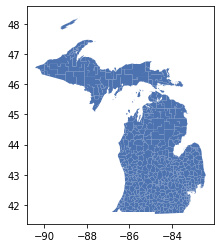

In [3]:
print(len(results))
joined = geo_join(results)
joined.loc[26].plot()

In [4]:
dperr = cube(joined.loc[[
    f for f in joined.index.get_level_values("State FIPS Code").unique()
    if f not in [2, 15]
]]["error_dp_per_child_eligible"])
dpmin = dperr.min()
dpmax = dperr.max()
serr = cube(joined.loc[[
    f for f in joined.index.get_level_values("State FIPS Code").unique()
    if f not in [2, 15]
]]["error_per_child_eligible"])
smin = serr.min()
smax = serr.max()
ymin = smin if smin <= dpmin else dpmin
ymax = smax if smax >= dpmax else dpmax

heatmap(
    joined.loc[[
        f for f in joined.index.get_level_values("State FIPS Code").unique()
        if f not in [2, 15]
    ]],
    label="Misallocation per eligible child (cube root)",
    y="error_dp_per_child_eligible",
    file="misalloc_nation.png",
    figsize=(15,10),
    bar_location = 'right'
    # min=ymin,
    # max=ymax
)

heatmap(
    joined.loc[[
        f for f in joined.index.get_level_values("State FIPS Code").unique()
        if f not in [2, 15]
    ]],
    y="error_per_child_eligible",
    label="Misallocation per eligible child (cube root)",
    file="misalloc_nation_sampling.png",
    figsize=(15,10),
    bar_location = 'right',
    min=ymin,
    max=ymax
)
heatmap(
    joined.loc[[
        f for f in joined.index.get_level_values("State FIPS Code").unique()
        if f not in [2, 15]
    ]],
    y="dp_marginal",
    label="Misallocation per eligible child (cube root)",
    file="misalloc_nation_marginal.png",
    figsize=(15,10),
    bar_location = 'right'
)

All but 4019 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 13.730431871026237
All but 4876 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.466269511766218
All but 5266 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 13.730431871026237


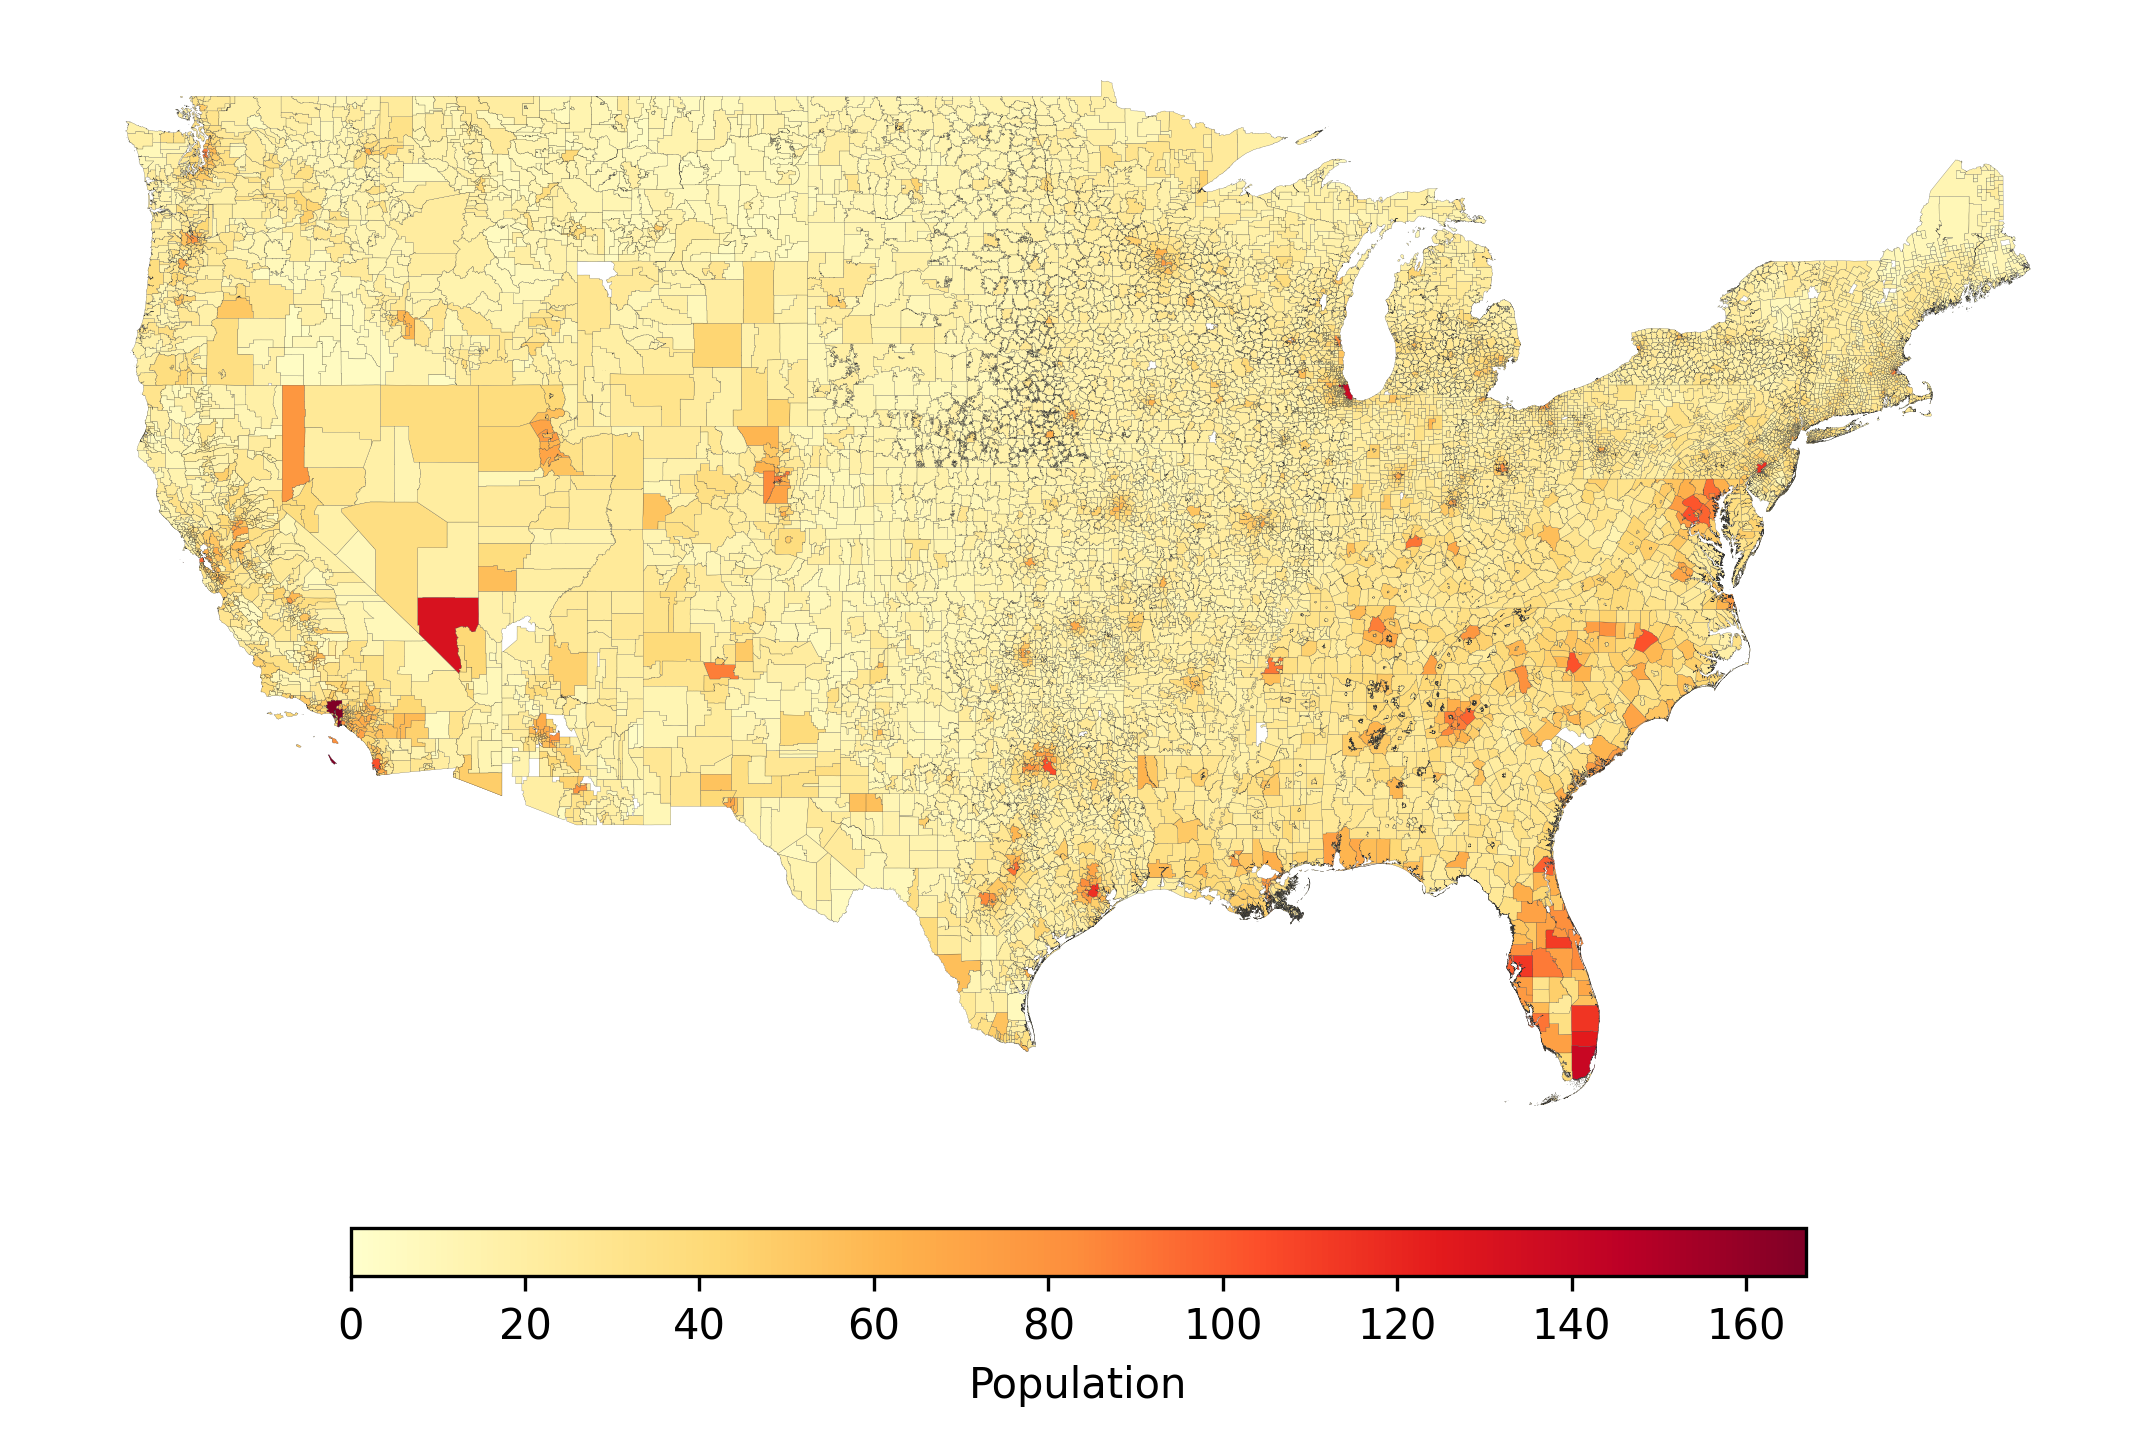

In [12]:
heatmap(
    joined.loc[[
        f for f in joined.index.get_level_values("State FIPS Code").unique()
        if f not in [2, 15]
    ]],
    "Population",
    vcenter=None,
    y="true_pop_total",
    theme="YlOrRd"
)

In [12]:
acs = get_acs_unified()
joined_acs = joined.join(acs['White (RACE) - pct'], how="left")
joined_acs["prop_nonwhite"] = 1 - pd.to_numeric(joined_acs['White (RACE) - pct'], errors='coerce') / 100
joined_acs.prop_nonwhite.describe()
for state in [
#     (26, "Michigan"),
#     (37, "North Carolina"),
    # (72, "Puerto Rico"),
    (42, "Pennsylvania")
]:
    # heatmap(joined_acs.loc[state[0]], "Prop. non-white-only", y="prop_nonwhite", transform=None, vcenter=None, theme="Blues")
    # heatmap(joined.loc[state[0]], "% switched eligibility for any grant", y="switched_eligibility", transform=None, vcenter=None, theme="Oranges")
    heatmap(
        joined.loc[state[0]], 
        "% became ineligible for any grant", 
        file="ineligible.png",
        y="became_ineligible", 
        transform=None, 
        vcenter=None, 
        theme="Oranges",
        min=0,
        max=1
    )
    heatmap(
        joined.loc[state[0]], 
        "% became ineligible for any grant", 
        file="ineligible_dp.png",
        y="became_ineligible_dp", 
        transform=None, 
        vcenter=None, 
        theme="Oranges",
        min=0,
        max=1
    )
    heatmap(
        joined.loc[state[0]], 
        "% became eligible for any grant", 
        file="eligible.png",
        y="became_eligible", transform=None, vcenter=None, theme="Greens",
        min=0,
        max=1
    )
    heatmap(
        joined.loc[state[0]], 
        "% became eligible for any grant", 
        file="eligible_dp.png",
        y="became_eligible_dp", transform=None, vcenter=None, theme="Greens",
        min=0,
        max=1
    )
    # heatmap(joined.loc[state[0]], f"Misallocation per child in {state[1]} (cube root)")
    # heatmap(joined.loc[state[0]], f"Misallocation per eligible child in {state[1]} (cube root)", y="error_per_child_eligible")
    # heatmap(joined.loc[state[0]], "Log eligible children", y="true_children_eligible", transform='log', vcenter=None, theme="Purples")
    # heatmap(joined.loc[state[0]], "% eligible children", y="percent_eligible", transform=None, vcenter=None, theme="Purples")
    # heatmap(joined.loc[state[0]], "Log population", y="true_pop_total", transform='log', vcenter=None, theme="Greens")
    # heatmap(joined.loc[state[0]], "Log status quo entitlement", y="true_grant_total", transform='log', vcenter=None, theme="Greens")

[INFO] Successfully imputed 1573 new indices
[INFO] Successfully imputed 1573 new indices
[INFO] Successfully imputed 1573 new indices
[INFO] Successfully imputed 1573 new indices


/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


All but 39 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 0.026017102035798146


/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


All but 31 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 0.02602038082347368


/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


All but 286 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 0.02601996449238455


/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


All but 270 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 0.026019600197216924


### Random forest

In [24]:
from sklearn.ensemble import RandomForestRegressor

averaged = results.groupby(["State FIPS Code", "District ID"]).mean().join(acs[variables], how="inner")
averaged["misalloc"] = averaged.est_grant_total - averaged.true_grant_total
averaged = averaged.replace('-', np.nan).replace('250,000+', '250000').dropna()
averaged = averaged.fillna(averaged.mean(skipna=True))

In [25]:
from sklearn.tree import plot_tree, DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=4)
features = [
    'Total population (RACE) - est',
    'White (RACE) - pct',
    'Black or African American (RACE) - pct',
#     'Cherokee tribal grouping (RACE) - pct',
#     'Chippewa tribal grouping (RACE) - pct',
#     'Navajo tribal grouping (RACE) - pct',
#     'Sioux tribal grouping (RACE) - pct',
    'Asian (RACE) - pct',
#     'Asian Indian (RACE) - pct',
#     'Chinese (RACE) - pct',
#     'Filipino (RACE) - pct',
#     'Japanese (RACE) - pct',
#     'Korean (RACE) - pct',
#     'Vietnamese (RACE) - pct',
#     'Other Asian (RACE) - pct',
#     'Native Hawaiian (RACE) - pct',
#     'Guamanian or Chamorro (RACE) - pct',
#     'Samoan (RACE) - pct',
#     'Some other race (RACE) - pct',
    'Median household income (dollars) (INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)) - est',
    'Foreign born (PLACE OF BIRTH) - pct',
    'Language other than English (LANGUAGE SPOKEN AT HOME) - pct',
    'Renter-occupied (HOUSING TENURE) - pct'
]
print(averaged[features].columns)
dt.fit(
    averaged[features],
    averaged.misalloc
)

Index(['Total population (RACE) - est', 'White (RACE) - pct',
       'Black or African American (RACE) - pct', 'Asian (RACE) - pct',
       'Median household income (dollars) (INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)) - est',
       'Foreign born (PLACE OF BIRTH) - pct',
       'Language other than English (LANGUAGE SPOKEN AT HOME) - pct',
       'Renter-occupied (HOUSING TENURE) - pct'],
      dtype='object')


DecisionTreeRegressor(max_depth=4)

In [26]:
importances = dt.feature_importances_
print(dt.n_features_)
importances

8


array([9.60892670e-01, 2.06042894e-02, 0.00000000e+00, 1.82353866e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.67654128e-04])

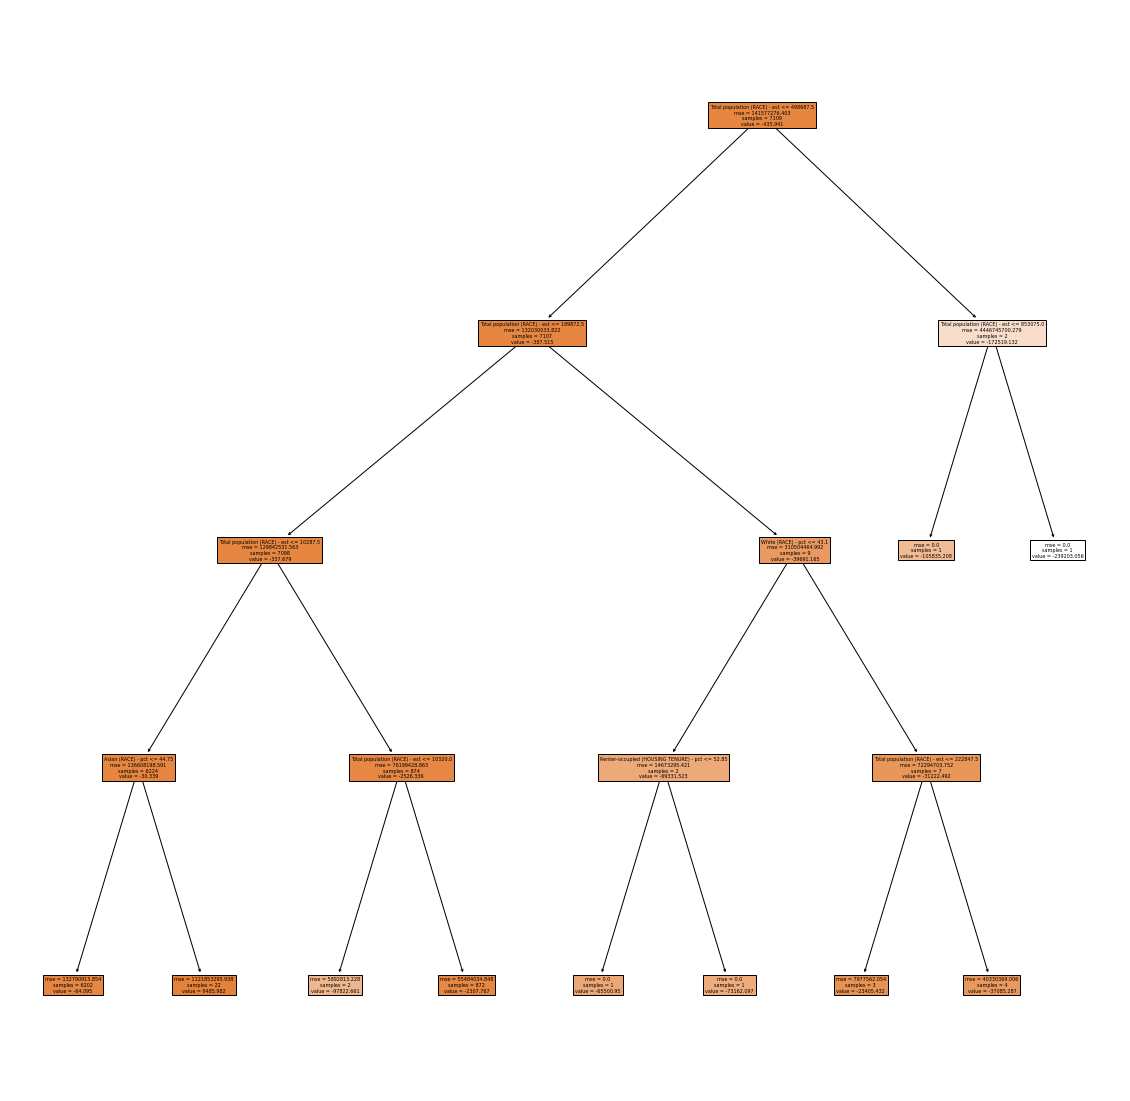

In [27]:
plt.rcParams['figure.figsize'] = [20, 20]
plot_tree(
    dt,
    feature_names = features,
    filled=True
)
plt.show()

### Plot for just (2.52, 0.0)-DP

In [18]:
grants = calc_total(funding(saipe, SonnenbergAuthorizer, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"), weighting))
grants_gaus = calc_total(funding(saipe, SonnenbergAuthorizer, Gaussian(saipe, 2.52, 0.2), get_sppe("../data/sppe18.xlsx"), weighting))
error = grants.true_grant_total/sum(grants.true_grant_total) - grants.est_grant_total/sum(grants.est_grant_total)
error_gaus = grants_gaus.true_grant_total/sum(grants_gaus.true_grant_total) - grants_gaus.est_grant_total/sum(grants_gaus.est_grant_total)

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


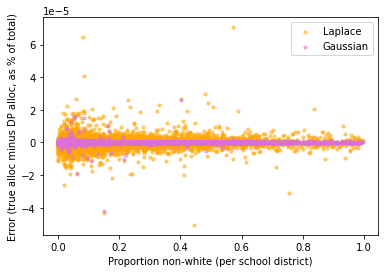

In [241]:
grants['prop_nonwhitealone'] = 1 - grants.race_2est / grants.race_1est
grants.prop_nonwhitealone[saipe.prop_nonwhitealone.isna()] = 0

plt.scatter(grants.prop_nonwhitealone, error, s=10, alpha=0.5, color='orange', label="Laplace")
plt.scatter(grants.prop_nonwhitealone, error_gaus, s=10, alpha=0.5, color='orchid', label="Gaussian")
ax = plt.gca()
ax.legend()
plt.xlabel("Proportion non-white (per school district)")
plt.ylabel("Error (true alloc minus DP alloc, as % of total)")
plt.show()

## Experimental treatments

In [2]:
experiment_kwargs = dict(
  trials = 1000,
  eps = [0.1],
  delta = [0.0],
  baseline = load_treatments("baseline")['baseline']
)

In [4]:
experiment_kwargs['baseline']['true_children_eligible'].describe()

count    1.319000e+07
mean     6.459567e+02
std      2.982825e+03
min      0.000000e+00
25%      5.500000e+01
50%      1.530000e+02
75%      4.290000e+02
max      1.529460e+05
Name: true_children_eligible, dtype: float64

### Hold harmless provision

[INFO] Successfully imputed 2937 new indices
-- WARNING: dropping some balances from total budget --
Puerto Rico 412450771.2306171
County balances 723748.7996060263
Part D Subpart 2 104168000.98352575
Comparing at eps= 0.1
13190000

# No hold harmless
True budget: 11661575735226.518
DP est budget: 11661575735226.557
Avg prop. districts erroneously ineligible: 2439.857
RMSE: 829785.5742881171
Avg. (per trial) # of districts losing $$: 6324.793
Total avg. (per sd) losses: 135950915.54662538
Total 5% quantile losses: 4367650960.775232
Total avg. losses (data error): 107981053.4604863
Avg. marginal losses (DP): 41329972.45196125
13190000

# Hold harmless
True budget: 11661575735226.518
DP est budget: 11661575735226.537
Avg prop. districts erroneously ineligible: 2440.489
RMSE: 637777.1455179425
Avg. (per trial) # of districts losing $$: 5186.054
Total avg. (per sd) losses: 484697307.4227537
Total 5% quantile losses: 1795436981.9322066
Total avg. losses (data error): 444768270.5505775
Avg. 

/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


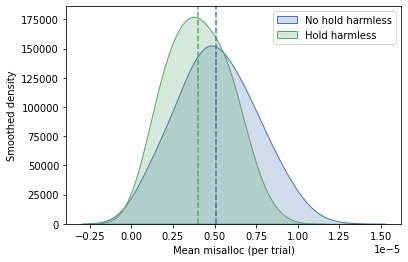

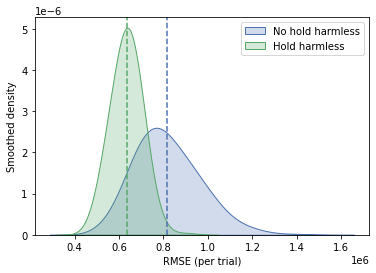

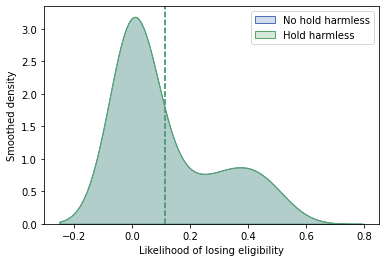

Plotting error_per_child


/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


All but 4899 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 3.681621884426111


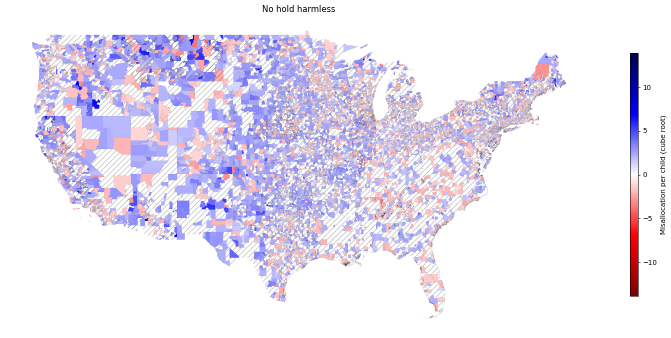

All but 1241 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 3.2265208307733064


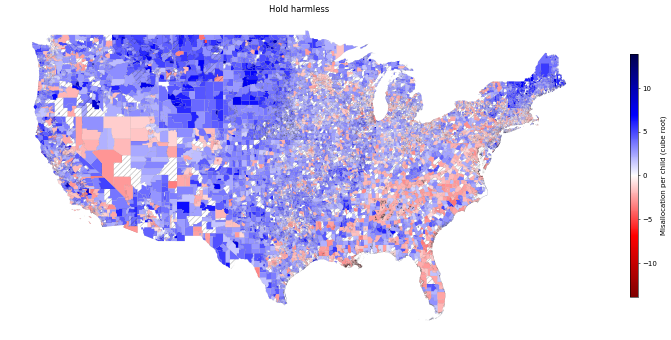

In [3]:
experiment = Experiment.get_experiment("hold_harmless", **experiment_kwargs)
experiment.plot()

### Post-processing

[INFO] Successfully imputed 2937 new indices
-- WARNING: dropping some balances from total budget --
Puerto Rico 412450771.2306171
County balances 723748.7996060263
Part D Subpart 2 104168000.98352575
Comparing at eps= 0.1
13190000

# None
True budget: 11661575735226.518
DP est budget: 11661575735226.54
Avg prop. districts erroneously ineligible: 2445.051
RMSE: 835441.3819086334
Avg. (per trial) # of districts losing $$: 6333.418
Total avg. (per sd) losses: 132288033.75349191
Total 5% quantile losses: 4369149671.826872
Total avg. losses (data error): 105749225.62118691
Avg. marginal losses (DP): 39337672.63122431
13190000

# Clipping
True budget: 11661575735226.518
DP est budget: 11661575735226.557
Avg prop. districts erroneously ineligible: 2439.857
RMSE: 829785.5742881171
Avg. (per trial) # of districts losing $$: 6324.793
Total avg. (per sd) losses: 135950915.54662538
Total 5% quantile losses: 4367650960.775232
Total avg. losses (data error): 107981053.4604863
Avg. marginal losses (

/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


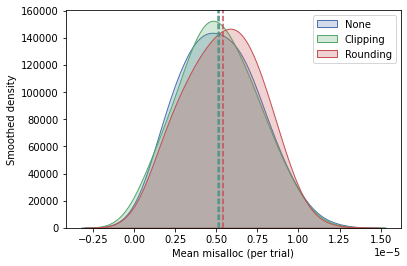

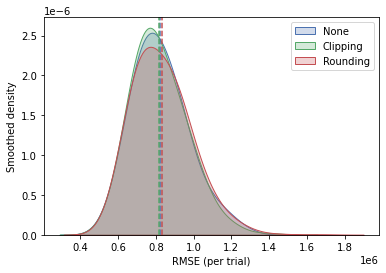

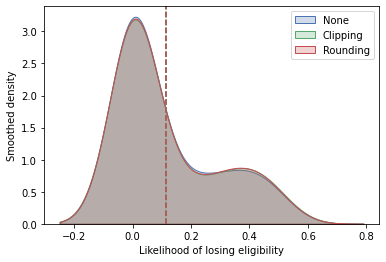

Plotting error_per_child


/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


All but 4922 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 3.6951314200561693


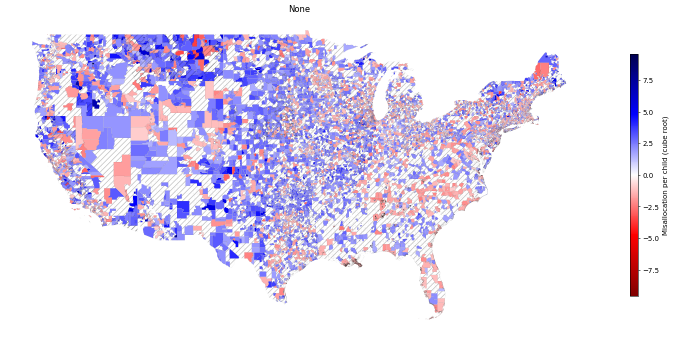

All but 4899 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 3.681621884426111


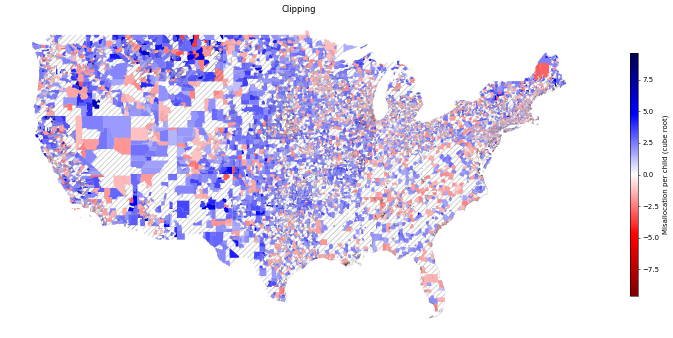

All but 4882 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 3.7002153265098356


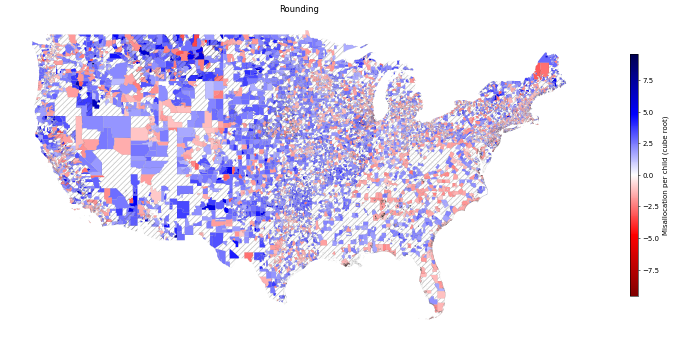

In [4]:
experiment = Experiment.get_experiment("post_processing", **experiment_kwargs)
experiment.plot()

### Moving average

[INFO] Successfully imputed 2937 new indices
-- WARNING: dropping some balances from total budget --
Puerto Rico 412450771.2306171
County balances 723748.7996060263
Part D Subpart 2 104168000.98352575
Comparing at eps= 0.1
13190000

# lag_0
True budget: 11661575735226.54
DP est budget: 11661575735226.557
Avg prop. districts erroneously ineligible: 2406.977
RMSE: 830362.1324993657
Avg. (per trial) # of districts losing $$: 6318.448
Total avg. (per sd) losses: 143088452.84247988
Total 5% quantile losses: 4367650960.775232
Total avg. losses (data error): 114864333.29644847
Avg. marginal losses (DP): 41329972.45196125
13190000

# lag_1
True budget: 11661575735226.54
DP est budget: 11661575735226.559
Avg prop. districts erroneously ineligible: 1366.629
RMSE: 59554.51334521331
Avg. (per trial) # of districts losing $$: 6565.244
Total avg. (per sd) losses: 59708413.49625921
Total 5% quantile losses: 839319711.0065503
Total avg. losses (data error): 14538739.476104042
Avg. marginal losses (DP)

/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


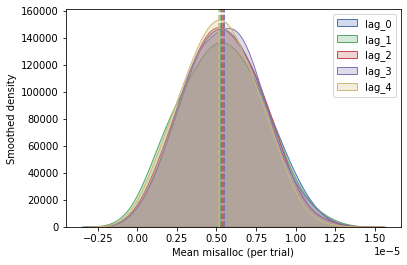

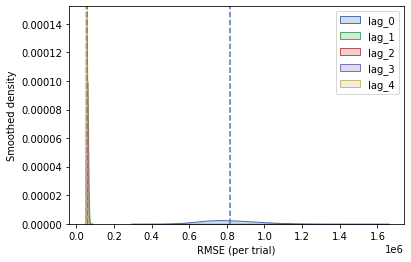

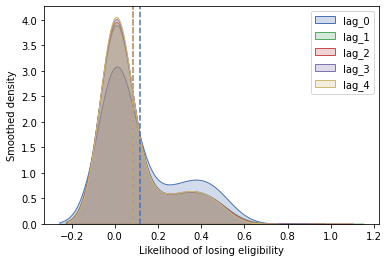

Plotting error_per_child


/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-p

All but 4659 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 3.5939306688045924


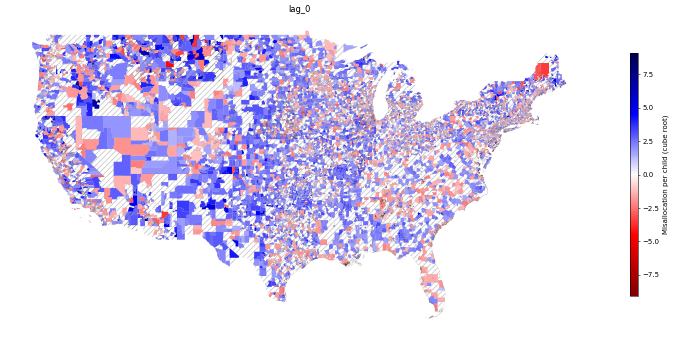

All but 2987 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 2.6978294321237786


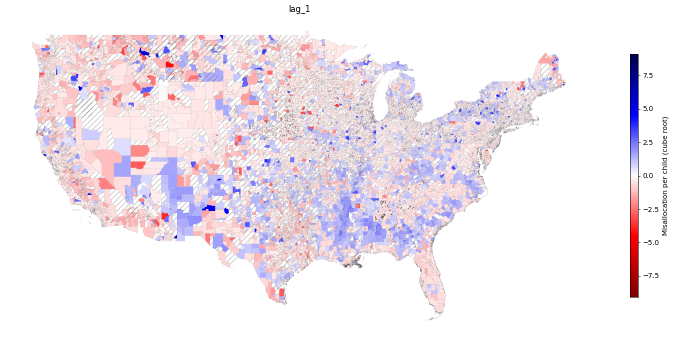

All but 2477 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 2.538515395752286


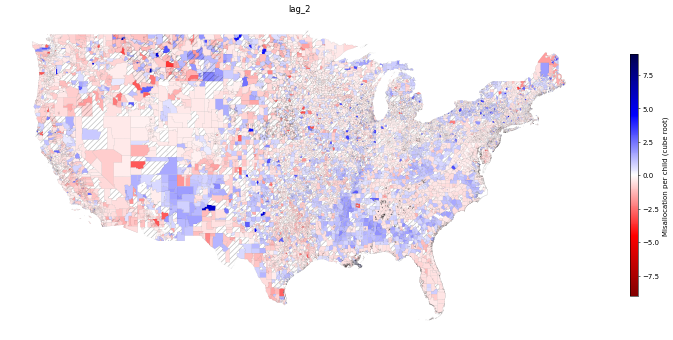

All but 4612 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 2.699289935732144


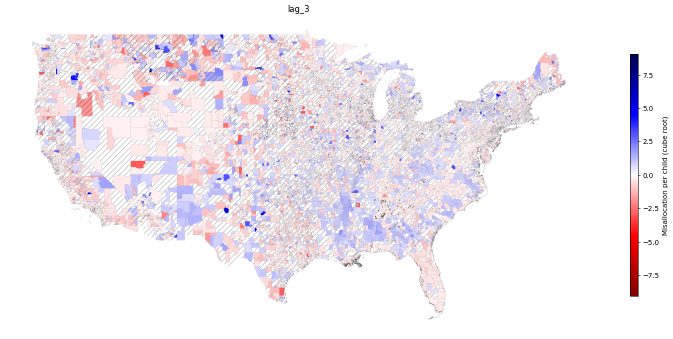

All but 7759 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 2.293114747943712


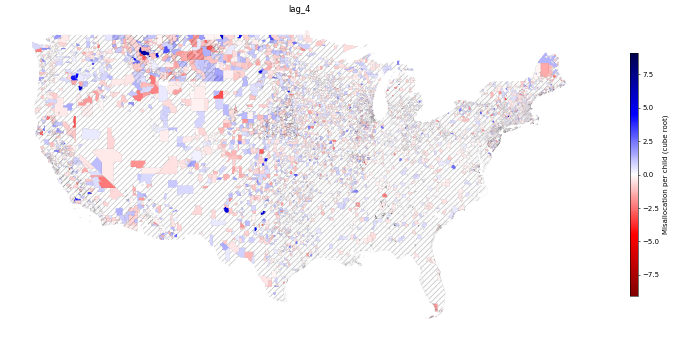

In [5]:
experiment = Experiment.get_experiment("moving_average", **experiment_kwargs)
experiment.plot()

### Alternative thresholding

[INFO] Successfully imputed 2937 new indices
-- WARNING: dropping some balances from total budget --
Puerto Rico 412450771.2306171
County balances 723748.7996060263
Part D Subpart 2 104168000.98352575
Comparing at eps= 0.1
13190000

# none
True budget: 11661575735226.518
DP est budget: 11661575735226.547
Avg prop. districts erroneously ineligible: 0.0
RMSE: 837703.2898374279
Avg. (per trial) # of districts losing $$: 5541.889
Total avg. (per sd) losses: 391589885.0004952
Total 5% quantile losses: 4074972963.798956
Total avg. losses (data error): 366639813.0147811
Avg. marginal losses (DP): 33691356.18133739
13190000

# hard
True budget: 11661575735226.518
DP est budget: 11661575735226.557
Avg prop. districts erroneously ineligible: 2439.857
RMSE: 829785.5742881171
Avg. (per trial) # of districts losing $$: 6324.793
Total avg. (per sd) losses: 135950915.54662538
Total 5% quantile losses: 4367650960.775232
Total avg. losses (data error): 107981053.4604863
Avg. marginal losses (DP): 41329

/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages

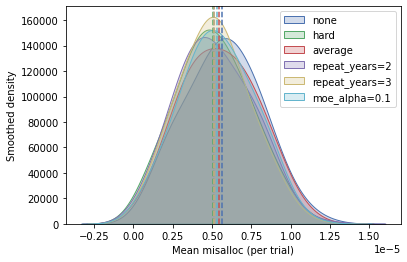

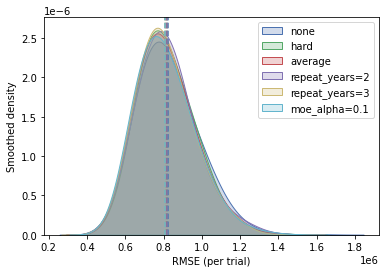

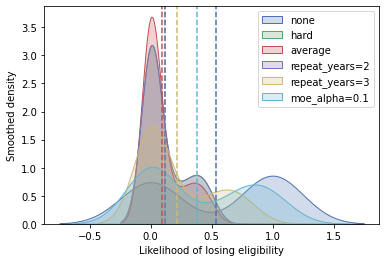

Plotting error_per_child


/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-p

All but 1918 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.275106419748512
All but 4876 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.466269511766218
All but 5845 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.3030592210572705
All but 4899 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.514384160897035
All but 5072 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.447606125519545
All but 3254 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.256065312185308


In [3]:
experiment = Experiment.get_experiment("thresholds", **experiment_kwargs)
experiment.plot()

### Epsilon Sensitivity

In [5]:
experiment = Experiment.get_experiment("epsilon", **experiment_kwargs)
experiment.plot()

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

### Budget increases

[INFO] Successfully imputed 2937 new indices
-- WARNING: dropping some balances from total budget --
Puerto Rico 412450771.2306171
County balances 723748.7996060263
Part D Subpart 2 104168000.98352575
Comparing at eps= 0.1
13190000

# lag_0
True budget: 11661575735226.54
DP est budget: 11661575735226.557
Avg prop. districts erroneously ineligible: 2406.977
RMSE: 830362.1324993657
Avg. (per trial) # of districts losing $$: 6318.448
Total avg. (per sd) losses: 143088452.84247988
Total 5% quantile losses: 4367650960.775232
Total avg. losses (data error): 114864333.29644847
Avg. marginal losses (DP): 41329972.45196125
13190000

# lag_1
True budget: 11661575735226.54
DP est budget: 11661575735226.559
Avg prop. districts erroneously ineligible: 1366.629
RMSE: 59554.51334521331
Avg. (per trial) # of districts losing $$: 6565.244
Total avg. (per sd) losses: 59708413.49625921
Total 5% quantile losses: 839319711.0065503
Total avg. losses (data error): 14538739.476104042
Avg. marginal losses (DP)

/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


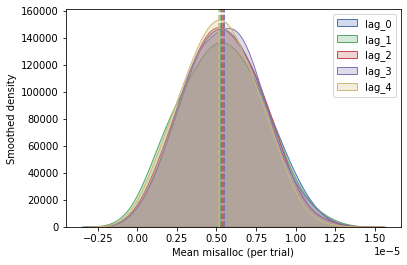

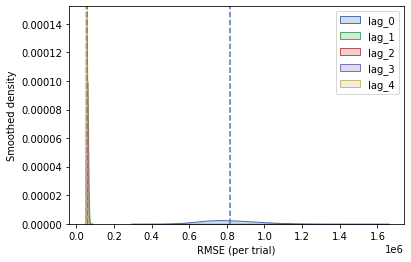

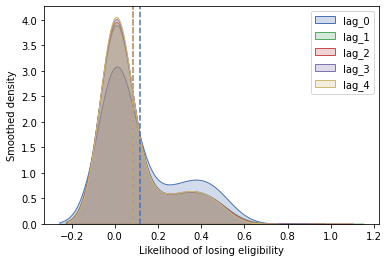

Plotting error_per_child


/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-p

All but 4636 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.466269511766218
All but 2964 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 3.5403861629118833
All but 2454 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 3.331316900336876
All but 4589 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 3.551116548331056
All but 7736 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 3.066700139576215


In [9]:
experiment = Experiment.get_experiment("moving_average", **experiment_kwargs)
experiment.plot()